# CNN For Instance Segmentation of Waste Detection

---

Commonly, CNNs have been used for image classification tasks while more advanced models like RCNN, YOLO, Mask-RCNN, etc have built upon it to extend the task of image classification to object detection, tracking, and instance segmentation. 

In this notebook, we detail a simple CNN approach to the classic problem of instance segmentation on a custom dataset of waste images taken from a common school cafeteria. 

In particular, our model seeks to identify the frequency of each different type of food given a video frames of waste footage. This model is then compared to a Mask-RCNN on the same dataset (separate notebook) for evaluation. 

## Install and Import Dependencies

---
Install and import the necessary dependencies to process the images and run the CNN for instance segmentation. 



In [ ]:
!pip install torchinfo

In [ ]:
#import dependencies 
import json 
import torch
import torchvision
import torchinfo
import numpy as np
import matplotlib.pyplot as plt
import skimage
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import Subset
from torch.utils.data import random_split
from skimage import io, transform
from torchvision import transforms, utils

import tqdm
from tqdm import tqdm

%matplotlib inline

In [ ]:
import os
os.chdir('/content/drive/My Drive/CS4641 Project')

## Data Preprocessing


---

Contains the classes that extend PyTorch's Dataset and Dataloader classes in order to parse our own custom dataset and load and shuffle them in batches.  


##### **Annotations Class**
Class to parse given annotations corresponding to an image directory and get the images' gold labels as a dictionary containing the image filename and an array of its instance frequencies. 

In [ ]:
from collections import namedtuple

class Annotation():

  def __init__(self, annotation_dir):
    self.annotations = json.load(open(annotation_dir))
    self.goldLabels = {}
    self.labels = {}
    self.numImages = len(self.annotations['images'])
    for annotation in self.annotations['annotations']:
      image_id = annotation['image_id']
      if image_id not in self.labels:
          self.labels[image_id] = []
      self.labels[image_id].append(annotation)

  def printCategories(self):
    for category in self.annotations['categories']:
        class_id = category['id']
        class_name = category['name']
        print(class_id, class_name)

  def getCategoriesGivenImage(self, idx):
    result = []
    for i in range(0, len(self.labels[idx])):
      result.append(self.labels[idx][i]['category_id'])
    
    return result

  def getCategoryDistribution(self): 
    distribution = np.zeros(9)
    for i in range (0, int(self.numImages)):
      image = self.annotations['images'][i]
      image_id = image['id']
      image_annotations = self.labels[image_id]
      for j in range (0, len(image_annotations)):
        index = image_annotations[j]['category_id'] - 1
        distribution[index] += 1

    return distribution


  def loadLabels(self):
    goldLabels = {}
    for i in range(0, int(self.numImages)):
      image = self.annotations['images'][i]
      image_id = image['id']
      label_template = {
          1: 0, # beef
          2: 0, # chicken
          3: 0, # pasta
          4: 0, # pizza
          5: 0, # fruit
          6: 0, # vegetable
          7: 0, # rice
          8: 0, # beans
          9: 0, # bread
      }

      try:
          image_file_name = image['file_name']
          image_annotations = self.labels[image_id]
          for j in range (0, len(image_annotations)):
            label_template[image_annotations[j]['category_id']] += 1

          goldLabels[image_file_name] = [
              label_template[1],
              label_template[2],
              label_template[3],
              label_template[4],
              label_template[5],
              label_template[6],
              label_template[7],
              label_template[8],
              label_template[9],
          ]
      except KeyError as key:
          print("Image with issing key: {}".format(image_id, key))
      
    return goldLabels


##### **Extend Pytorch Dataset class for Custom Waste Images**

Classes to parse and transform our custom dataset. Including rescaling transforms and re-odering of the image dimensions before the CNN.  

In [ ]:
from torch.utils.data import Dataset

class WasteFrameDataset(Dataset):
  def __init__(self, imagePath, goldLabels = None, transform=None): 
    """
    Args: 
      imagePath (string): Path to the Image Directory 
      goldLabels (dictionary): Dictionary of the Image name with a tuple of its gold labels 
    """
    self.goldLabels = goldLabels
    self.imagePath = imagePath
    self.imageNames = os.listdir(imagePath)  # array of all the files name in the image path directory 
    self.transform = transform

  def __len__(self): 
    return len(self.imageNames)

  def __getitem__(self, index):
    image = io.imread(self.imagePath + '/' + self.imageNames[index])

    sample =  {
        'image': image,
        'label': torch.FloatTensor(self.goldLabels[self.imageNames[index]])
    }

    # print(self.goldLabels[self.imageNames[index]])
    if self.transform:
      sample = self.transform(sample)

    return sample

class Rescale(object): 
  def __init__(self, output_height, output_width):
    self.output_height = output_height
    self.output_width = output_width

  def __call__(self, sample): 
    image, label = sample['image'], sample['label']

    img = transform.resize(image, (self.output_height, self.output_width))

    return {
        'image': img,
        'label': label
    }
  
class ToTensor(object):
  def __call__(self, sample):
    image, label = sample['image'], sample['label']

    image = image.transpose((2, 0, 1))

    return {
        'image': image,
        'label': label
    }

Parse the given annotation file and display the data distribution of the frequencies of each class

[7, 7, 7]
[ 19.  25.  19.  37.  24. 200.  84.  20.  33.]


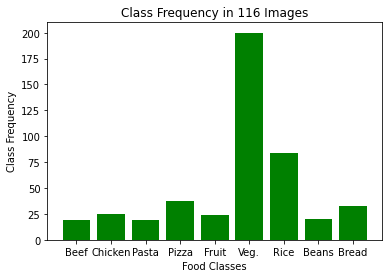

In [ ]:
# Load in the labels for given set
train_labels = Annotation('./labels_116Images_2021-12-01-06-45-38.json')
trainGoldLabels = train_labels.loadLabels()
print(train_labels.getCategoriesGivenImage(23))
print(train_labels.getCategoryDistribution())

x = ['Beef', 'Chicken', 'Pasta', 'Pizza', 'Fruit', 'Veg.', 'Rice', 'Beans', 'Bread']
y = train_labels.getCategoryDistribution().tolist()

x_pos = [0, 1, 2, 3, 4, 5, 6, 7, 8]

plt.bar(x_pos, y, color='green')
plt.xlabel("Food Classes")
plt.ylabel("Class Frequency")
plt.title("Class Frequency in 116 Images")

plt.xticks(x_pos, x)
plt.show()

Fetch all the images and pass them to the Dataset class we created earlier so we can match the labels with the corresponding images and format them to that PyTorch's Dataloader class and recongnize them when we iterate our our data later for training and evaluation

116
(3, 540, 920)


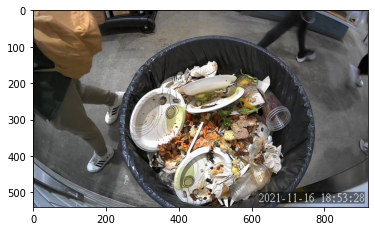

In [ ]:
IMAGE_DIR = "/content/drive/MyDrive/CS4641 Project/All_Images"
waste_dataset = WasteFrameDataset(IMAGE_DIR,
                                  trainGoldLabels,
                                  transform=transforms.Compose([Rescale(540, 920), ToTensor()]))
dataloader = DataLoader(waste_dataset, batch_size=4, shuffle=True, num_workers=0)

data_point = waste_dataset[1]
plt.imshow(data_point['image'].transpose((1,2,0)))

#### Display some sample training images

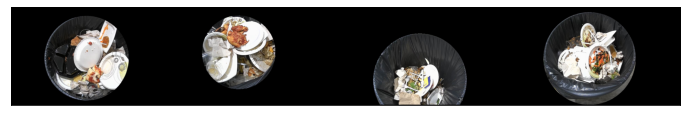

In [ ]:
from torchvision.utils import make_grid
from torchvision.io import read_image

import torchvision.transforms.functional as F

def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]
    fix, axs = plt.subplots(figsize = (12,12), ncols=len(imgs), squeeze=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = F.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])

data_dir = "./Masked_Train/"
img_files = os.listdir(data_dir)

img1 = read_image(data_dir + img_files[2])
img2 = read_image(data_dir + img_files[1])
img3 = read_image(data_dir + img_files[5])
img4 = read_image(data_dir + img_files[8])

grid = make_grid([img1, img2, img3, img4])
show(grid)

## Convolutional Neural Network Definition

---
Here we define our simple CNN with an output of the summary of the network given in the cells below. 


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Waste_CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 8, kernel_size=3, stride=1)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3, stride=1)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=3, stride=1)

        self.maxpool = nn.MaxPool2d(2,2)

        self.fc1 = nn.Linear(235040 ,1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 9)

    def forward(self, x):
        x = self.maxpool(F.relu(self.conv1(x)))

        x = self.maxpool(F.relu(self.conv2(x)))

        x = self.maxpool(F.relu(self.conv3(x)))

        x = torch.flatten(x, 1) # flatten all dimensions except batch

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
 
        return x

In [ ]:
from torchinfo import summary

model = Waste_CNN().cuda()
batch_size = 1
print(summary(model.cuda(), input_size=(1, 3, 540, 920)))

Layer (type:depth-idx)                   Output Shape              Param #
Waste_CNN                                --                        --
├─Conv2d: 1-1                            [1, 8, 538, 918]          224
├─MaxPool2d: 1-2                         [1, 8, 269, 459]          --
├─Conv2d: 1-3                            [1, 16, 267, 457]         1,168
├─MaxPool2d: 1-4                         [1, 16, 133, 228]         --
├─Conv2d: 1-5                            [1, 32, 131, 226]         4,640
├─MaxPool2d: 1-6                         [1, 32, 65, 113]          --
├─Linear: 1-7                            [1, 1024]                 240,681,984
├─Linear: 1-8                            [1, 512]                  524,800
├─Linear: 1-9                            [1, 9]                    4,617
Total params: 241,217,433
Trainable params: 241,217,433
Non-trainable params: 0
Total mult-adds (M): 631.73
Input size (MB): 5.96
Forward/backward pass size (MB): 54.82
Params size (MB): 964.87
Estimat

## Model Training (Hold-Out)

---
Train the model using hold out validation. Model is trained on the 116 images and evaluated on the 23 test images. See section below for 4-hold out cross validation which performs better due to the small sample size. 


In [ ]:
from torch import optim

EPOCH = 40
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.1)
MSE = nn.MSELoss()

for epoch in range(EPOCH):
  model.train()
  total_loss = 0.0

  for step, batch in enumerate(tqdm(dataloader)):
    optimizer.zero_grad()

    images, labels = batch['image'].cuda(), batch['label'].cuda()
    images = images.float()
    output = model(images)

    loss = MSE(output, labels)
    total_loss += loss

    loss.backward()
    optimizer.step()
  
  print('Loss', total_loss.tolist())



##### **Save the Model**

In [ ]:
SAVE_MODE = ""
MODEL_NAME = ""
PATH = "/content/drive/MyDrive/CS4641 Project/CNN Models/" + MODEL_NAME

if SAVE_MODE == "inference":
  torch.save(model.state_dict(), PATH)

## Evaluation (Hold-Out)

---



In [ ]:
def Eval(model, eval_loader, BATCH_SIZE):
  output_prob = 0
  total_check = 0

  model.eval()

  for step, batch in enumerate(eval_loader):
    images, labels = batch['image'].cuda(), batch['label'].cuda()
    images = images.float()
    output = model(images)

    for i in range (0, BATCH_SIZE):
      pred = np.around(F.relu(output).cpu().detach().numpy()[i])
      actual = labels.cpu().detach().numpy()[i]
      
      if np.linalg.norm(pred) > np.linalg.norm(actual):
        if np.dot(pred, actual) < 0:
          prob = 0
        else: 
          prob = (np.dot(pred, actual) / np.linalg.norm(pred)) / np.linalg.norm(pred)
      else:
        if np.dot(pred, actual) < 0:
          prob = 0
        else: 
          prob = (np.dot(pred, actual) / np.linalg.norm(actual)) / np.linalg.norm(actual)

      output_prob += round(prob, 2)
      total_check += 1

  return output_prob / total_check

**Evaluate on Training Set**

In [ ]:
training_accuracy = Eval(model, dataloader, 4)
training_accuracy

**Evaluation on Test Set**

In [ ]:
# Load in the labels for given set
test_labels = Annotation('/content/drive/MyDrive/CS4641 Project/labels_Test_23Images_2021-12-02-05-49-55.json')
testGoldLabels = test_labels.loadLabels()
print(test_labels.getCategoriesGivenImage(1))

[4, 4, 3, 3, 3, 3, 3]


23
(3, 540, 920)


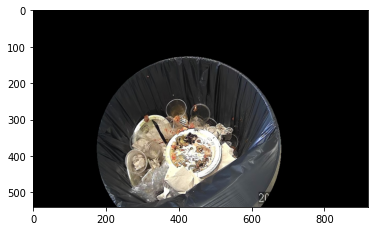

In [ ]:
TRAINING_IMAGE_DIR = "/content/drive/MyDrive/CS4641 Project/Masked_Test"
test_waste_dataset = WasteFrameDataset(TRAINING_IMAGE_DIR,
                                  testGoldLabels,
                                  transform=transforms.Compose([Rescale(540, 920), ToTensor()]))

print(len(test_waste_dataset))
data_point = test_waste_dataset[1]
print(data_point['image'].shape)
plt.imshow(data_point['image'].transpose((1,2,0)))

In [ ]:
test_dataloader = DataLoader(test_waste_dataset, batch_size=1, shuffle=True, num_workers=0)
accuracy = Eval(model, test_dataloader, 1)
accuracy

In [ ]:
# num_correct = 0
# num_correct_margin = 0
# total_check = 0

# model.eval()

# for step, batch in enumerate(test_dataloader):

#   images, labels = batch['image'].cuda(), batch['label'].cuda()
#   images = images.float()
#   output = model(images)

#   for i in range (0, 1):
#     pred = np.around(F.relu(output).cpu().detach().numpy()[i])
#     actual = labels.cpu().detach().numpy()[i]
    
#     if np.linalg.norm(pred) > np.linalg.norm(actual):
#       if np.dot(pred, actual) < 0:
#         prob = 0
#       else: 
#         prob = (np.dot(pred, actual) / np.linalg.norm(pred)) / np.linalg.norm(pred)
#     else:
#       if np.dot(pred, actual) / np.linalg.norm(actual) < 0:
#         prob = 0
#       else: 
#         prob = (np.dot(pred, actual) / np.linalg.norm(actual)) / np.linalg.norm(actual)

#     if (round(prob, 2) < 1):
#       print(prob)
#       print(pred)
#       print(actual)
#       print("----------------")

#     num_correct += round(prob, 2)
#     # if np.abs(np.sum(np.subtract(pred, actual))) <= 1:
#     #   if np.abs(np.sum(np.subtract(pred, actual))) == 1: 
#     #     num_correct_margin += 1
#     #   else: 
#     #     num_correct += 1
#     # else: 
#     #   print(np.abs(np.sum(np.subtract(pred, actual))))

#     total_check += 1
#     # print(np.around(F.relu(output).cpu().detach().numpy()[i]))
#     # print(labels.cpu().detach().numpy()[i])
#     # print('------')
#     # # print(np.sum(np.subtract(pred, actual)))
#     # print('------')

# print(total_check)
# print(num_correct/total_check)
# print(num_correct_margin/total_check)

## Cross Validation

---
Use a 4 hold out cross validation to access the accuracy of the model. Dataset of 116 images is partitioned into 4 groups of 29 images each and model accuracy is the average of the evaluation on four 29 image groups while the model is trained on the other 87 images 


In [ ]:
def reset_weights(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
        m.reset_parameters()

In [ ]:
from torch import optim

# Cross Validation: 
# 0 - 87 | 87 - 116
# 0 - 29 | 29 - 116
# 29 - 58 | 0 - 29 && 58 - 116
# 58 - 87 | 0 - 58 && 87 - 116
splits = [(0, 29), (29, 58), (58, 87), (87, 116)]

BATCH_SIZE = 1
average_output = 0

matplotlibArr = []
accuracymatplotLib = []
train_accuracymatplotLib = []

optimizer = optim.Adam(model.parameters(), lr=0.001)

for idx, split in enumerate(splits):
  matplotlibArr.append([])
  accuracymatplotLib.append([])
  train_accuracymatplotLib.append([])

  training_subset_range = list(range(0, split[0])) + list(range(split[1], 116))
  test_subset_range = list(range(split[0], split[1]))

  train_subset = Subset(waste_dataset, training_subset_range)
  val_subset = Subset(waste_dataset, test_subset_range)

  train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
  test_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

  # reset the weights of the model
  model.apply(reset_weights)
  
  # train
  EPOCH = 20

  MSE = nn.MSELoss()

  for epoch in range(EPOCH):
    model.train()
    total_loss = 0.0

    for step, batch in enumerate(tqdm(train_loader)):
      optimizer.zero_grad()

      images, labels = batch['image'].cuda(), batch['label'].cuda()
      images = images.float()
      output = model(images)

      loss = MSE(output, labels)
      total_loss += loss

      loss.backward()
      optimizer.step()
    
    print('Loss', total_loss.tolist())
    matplotlibArr[idx].append(total_loss.tolist())

    accuracy = Eval(model, test_loader, BATCH_SIZE)
    train_accuracy = Eval(model, train_loader, BATCH_SIZE)

    accuracymatplotLib[idx].append(round(accuracy, 2))
    train_accuracymatplotLib[idx].append(round(train_accuracy, 2))

  # evaluate
  average_output += Eval(model, test_loader, BATCH_SIZE)
  print("Ouput", average_output / 4)
  

100%|██████████| 87/87 [00:23<00:00,  3.65it/s]


Loss 105.89559936523438


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 73.8195571899414


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 65.677734375


100%|██████████| 87/87 [00:22<00:00,  3.91it/s]


Loss 63.6806755065918


100%|██████████| 87/87 [00:21<00:00,  3.99it/s]


Loss 48.52797317504883


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 39.9904670715332


100%|██████████| 87/87 [00:21<00:00,  4.06it/s]


Loss 34.71184539794922


100%|██████████| 87/87 [00:21<00:00,  4.05it/s]


Loss 43.12333679199219


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 37.072757720947266


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 20.916549682617188


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 13.933749198913574


100%|██████████| 87/87 [00:21<00:00,  4.07it/s]


Loss 12.213517189025879


100%|██████████| 87/87 [00:20<00:00,  4.18it/s]


Loss 7.908870697021484


100%|██████████| 87/87 [00:20<00:00,  4.15it/s]


Loss 10.391518592834473


100%|██████████| 87/87 [00:21<00:00,  4.12it/s]


Loss 10.643538475036621


100%|██████████| 87/87 [00:20<00:00,  4.28it/s]


Loss 5.555558681488037


100%|██████████| 87/87 [00:20<00:00,  4.14it/s]


Loss 7.646402359008789


100%|██████████| 87/87 [00:20<00:00,  4.17it/s]


Loss 5.20330810546875


100%|██████████| 87/87 [00:20<00:00,  4.16it/s]


Loss 6.3840742111206055


100%|██████████| 87/87 [00:21<00:00,  4.12it/s]


Loss 8.371509552001953
Ouput 0.03327586232074376


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 300.9627990722656


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 65.16351318359375


100%|██████████| 87/87 [00:20<00:00,  4.15it/s]


Loss 63.1660270690918


100%|██████████| 87/87 [00:20<00:00,  4.20it/s]


Loss 62.451515197753906


100%|██████████| 87/87 [00:21<00:00,  4.13it/s]


Loss 62.432552337646484


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 61.570411682128906


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 62.45260238647461


100%|██████████| 87/87 [00:20<00:00,  4.15it/s]


Loss 61.60609817504883


100%|██████████| 87/87 [00:20<00:00,  4.17it/s]


Loss 61.785675048828125


100%|██████████| 87/87 [00:21<00:00,  4.07it/s]


Loss 62.0985107421875


100%|██████████| 87/87 [00:21<00:00,  4.05it/s]


Loss 62.3857307434082


100%|██████████| 87/87 [00:21<00:00,  4.10it/s]


Loss 61.069950103759766


100%|██████████| 87/87 [00:21<00:00,  4.08it/s]


Loss 62.401954650878906


100%|██████████| 87/87 [00:21<00:00,  4.06it/s]


Loss 61.88439178466797


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 61.537391662597656


100%|██████████| 87/87 [00:21<00:00,  4.14it/s]


Loss 61.80845642089844


100%|██████████| 87/87 [00:20<00:00,  4.16it/s]


Loss 62.346893310546875


100%|██████████| 87/87 [00:21<00:00,  4.05it/s]


Loss 61.8099479675293


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 61.41883087158203


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 61.63087463378906
Ouput 0.12301724291695604


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 256.2574462890625


100%|██████████| 87/87 [00:21<00:00,  4.08it/s]


Loss 80.66761779785156


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 79.81439208984375


100%|██████████| 87/87 [00:21<00:00,  4.12it/s]


Loss 78.44603729248047


100%|██████████| 87/87 [00:21<00:00,  4.07it/s]


Loss 78.12236022949219


100%|██████████| 87/87 [00:21<00:00,  4.09it/s]


Loss 78.94892883300781


100%|██████████| 87/87 [00:21<00:00,  4.06it/s]


Loss 77.89273834228516


100%|██████████| 87/87 [00:21<00:00,  4.08it/s]


Loss 78.94236755371094


100%|██████████| 87/87 [00:20<00:00,  4.21it/s]


Loss 77.72916412353516


100%|██████████| 87/87 [00:21<00:00,  4.05it/s]


Loss 78.0203628540039


100%|██████████| 87/87 [00:21<00:00,  4.14it/s]


Loss 78.50190734863281


100%|██████████| 87/87 [00:21<00:00,  4.08it/s]


Loss 78.15643310546875


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 79.0103759765625


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 77.8823013305664


100%|██████████| 87/87 [00:20<00:00,  4.17it/s]


Loss 77.89436340332031


100%|██████████| 87/87 [00:20<00:00,  4.19it/s]


Loss 78.1612319946289


100%|██████████| 87/87 [00:21<00:00,  4.13it/s]


Loss 77.71802520751953


100%|██████████| 87/87 [00:21<00:00,  4.09it/s]


Loss 78.81848907470703


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 77.42327880859375


100%|██████████| 87/87 [00:20<00:00,  4.16it/s]


Loss 78.26554870605469
Ouput 0.25155172742710546


100%|██████████| 87/87 [00:21<00:00,  4.09it/s]


Loss 1108.412841796875


100%|██████████| 87/87 [00:21<00:00,  4.11it/s]


Loss 84.73057556152344


100%|██████████| 87/87 [00:21<00:00,  4.05it/s]


Loss 67.84390258789062


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 53.368324279785156


100%|██████████| 87/87 [00:21<00:00,  4.12it/s]


Loss 38.897987365722656


100%|██████████| 87/87 [00:21<00:00,  4.10it/s]


Loss 28.561113357543945


100%|██████████| 87/87 [00:21<00:00,  3.99it/s]


Loss 22.98698616027832


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 19.277503967285156


100%|██████████| 87/87 [00:21<00:00,  3.98it/s]


Loss 12.0559663772583


100%|██████████| 87/87 [00:22<00:00,  3.93it/s]


Loss 6.909387111663818


100%|██████████| 87/87 [00:22<00:00,  3.93it/s]


Loss 5.485483646392822


100%|██████████| 87/87 [00:22<00:00,  3.94it/s]


Loss 4.178067684173584


100%|██████████| 87/87 [00:22<00:00,  3.95it/s]


Loss 4.708951950073242


100%|██████████| 87/87 [00:22<00:00,  3.94it/s]


Loss 3.106395721435547


100%|██████████| 87/87 [00:21<00:00,  3.96it/s]


Loss 2.5977611541748047


100%|██████████| 87/87 [00:22<00:00,  3.89it/s]


Loss 1.884843111038208


100%|██████████| 87/87 [00:21<00:00,  3.96it/s]


Loss 2.4735758304595947


100%|██████████| 87/87 [00:21<00:00,  4.02it/s]


Loss 1.9535475969314575


100%|██████████| 87/87 [00:21<00:00,  4.00it/s]


Loss 1.5201959609985352


100%|██████████| 87/87 [00:21<00:00,  4.03it/s]


Loss 1.1965878009796143
Ouput 0.3291379349659486


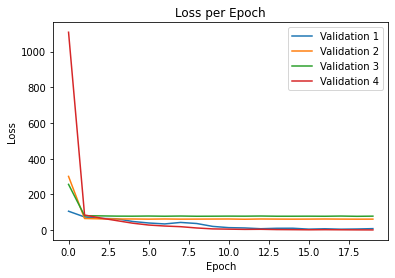

In [ ]:
x = list(range(0, 20))

plt.plot(x, matplotlibArr[0], label='Validation 1')  # Plot some data on the (implicit) axes.
plt.plot(x, matplotlibArr[1], label='Validation 2')  # etc.
plt.plot(x, matplotlibArr[2], label='Validation 3')
plt.plot(x, matplotlibArr[3], label='Validation 4')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title("Loss per Epoch")
plt.legend()


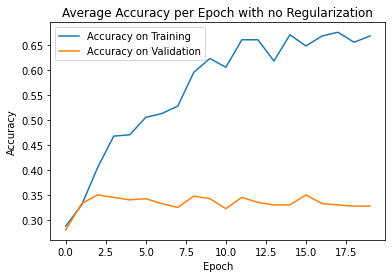

In [ ]:
a = np.array(train_accuracymatplotLib)
b = np.array(accuracymatplotLib)

plt.plot(x, np.mean(a, axis=0), label='Accuracy on Training') 
plt.plot(x, np.mean(b, axis=0), label='Accuracy on Validation')  # Plot some data on the (implicit) axes.
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Average Accuracy per Epoch with no Regularization")
plt.legend()